In [19]:
from collections import Counter
from io import BytesIO
import os
import json

from IPython.display import display
import numpy as np
from PIL import Image
import requests
import torch

In [2]:
data_path = '..'
img_dirs = (os.path.join(data_path, 'VG_100K'),
            os.path.join(data_path, 'VG_100K_2'))

In [3]:
image_data_path = os.path.join(data_path, 'image_data.json')
objects_path = os.path.join(data_path, 'objects.json')
attributes_path = os.path.join(data_path, 'attributes.json')

In [11]:
with open(objects_path, 'r') as objects_file:
    objects_info_list = json.loads(objects_file.read())
objects_info = {obj['image_id']: obj
                for obj in objects_info_list}

with open(attributes_path, 'r') as attributes_file:
    attributes_info_list = json.loads(attributes_file.read())
attributes_info = {attr['image_id']: attr
                   for attr in attributes_info_list}

In [38]:
objects_counter = Counter()
for objects_info_image in objects_info.values():
    for object_ in objects_info_image['objects']:
        for name in object_['names']:
            objects_counter[name] += 1
sorted_obj_items = sorted(objects_counter.items(), key=lambda u: (-u[1], u[0]))
vocabulary_objects = [item[0] for item in sorted_obj_items]
obj_to_ix = {name: ix for ix, name in enumerate(vocabulary_objects)}
        
attributes_counter = Counter()
vocabulary_attributes = set()
for attributes_info_image in attributes_info.values():
    for attributes_info_object in attributes_info_image['attributes']:
        for attribute in attributes_info_object.get('attributes', []):
            attributes_counter[attribute] += 1
sorted_attr_items = sorted(attributes_counter.items(), key=lambda u: (-u[1], u[0]))
vocabulary_attributes = [item[0] for item in sorted_attr_items]
att_to_ix = {name: ix for ix, name in enumerate(vocabulary_attributes)}

In [8]:
def get_img(img_id, url):
    if url is not None:
        url_split = url.split('/')
        img_name = url_split[-1]
    else:
        img_name = '{}.jpg'.format(img_id)
    for dir_path in img_dirs:
        image_path = os.path.join(dir_path, img_name)
        if os.path.isfile(image_path):
            return Image.open(image_path)
    if url is not None:
        r = requests.get(url)
        r.raise_for_status()
        image_path = os.path.join(dir_path, url_split[-2], img_name)
        with open(image_path, 'wb') as image_file:
            image_file.write(r.content)
        return Image.open(BytesIO(r.content))
    raise requests.exceptions.HTTPError

In [41]:
class WrongModeException(Exception):
    pass

def preprocess_image(objects_info_image, attributes_info_image, display_images=False):    
    img = get_img(img_id=objects_info_image['image_id'], url=objects_info_image.get('image_url', None))
    
    if img.mode != 'RGB':
        raise WrongModeException
    
    if display_images:
        display(img)
        print('Original image\n')

    objects = objects_info_image['objects']
    N = len(objects)

    attributes = attributes_info_image['attributes']
    attributes_dict = {object_['object_id']: object_.get('attributes', [])
                       for object_ in attributes}
    
    img_ids = np.ones(N, dtype=np.int) * objects_info_image['image_id']
    object_squares = np.empty((N, 3, 224, 224), dtype=np.uint8)
    original_sizes = np.empty(N, dtype=np.int)
    object_names = np.empty(N, dtype=np.int)
    attributes_names = []

    for i, (object_, attrs) in enumerate(zip(objects, attributes)):
        attrs = attributes_dict[object_['object_id']]
        attributes_names.append([att_to_ix[attr] for attr in attrs])
        original_sizes[i] = object_['w'] * object_['h']
        object_names[i] = obj_to_ix[object_['names'][0]]
        
        # Image processing
        cropped = img.crop((object_['x'],
                            object_['y'],
                            object_['x'] + object_['w'],
                            object_['y'] + object_['h']))
        resized = cropped.resize((224, 224))

        if display_images:
            display(resized)
            print(' - '.join(object_['names']))
            print()

        object_squares[i] = np.rollaxis(np.asarray(resized), axis=2, start=0)

    return object_squares, img_ids, original_sizes, object_names, attributes_names

In [42]:
an = preprocess_image(objects_info[2], attributes_info[2])[-1]

In [43]:
an

[[14],
 [37, 0],
 [13, 5, 15],
 [5, 4],
 [5],
 [0],
 [34, 0],
 [5],
 [25],
 [4, 32],
 [3],
 [3],
 [3],
 [25],
 [25],
 [0],
 [11],
 [25],
 [],
 [25],
 [43, 58644],
 [0],
 [],
 [1],
 [164]]

In [47]:
def generate_label_vector_attr(an, max_num_attribues):
    indices = torch.LongTensor([[i, v]
                                for i, attr_row in enumerate(an)
                                for v in attr_row
                                if v < max_num_attribues])
    values = torch.ones(len(indices))
    return torch.sparse.FloatTensor(indices.t(),
                                    values,
                                    torch.Size((len(an), max_num_attribues)))

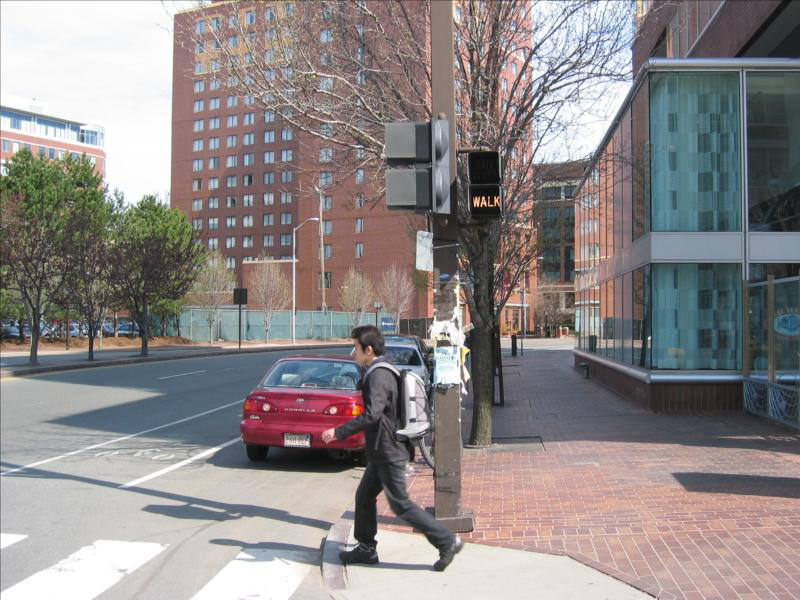

Original image



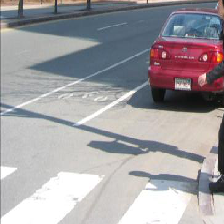

road



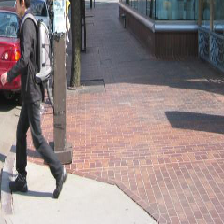

sidewalk



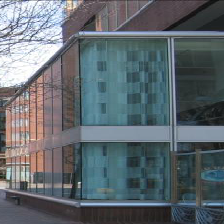

building



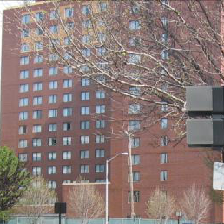

building



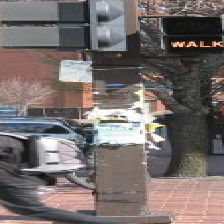

street light



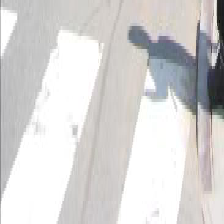

crosswalk



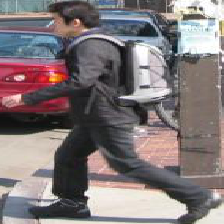

man



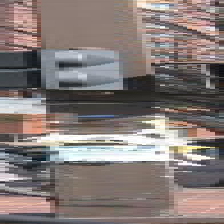

pole



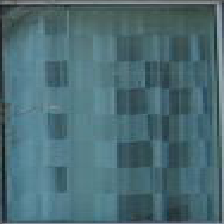

window



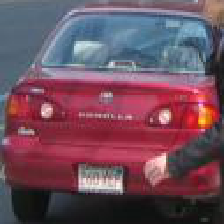

car



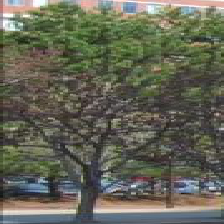

tree



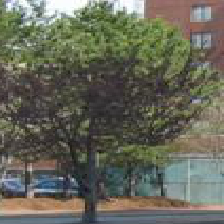

tree



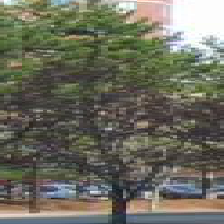

tree



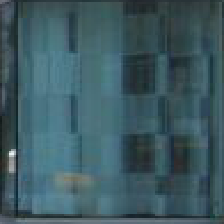

window



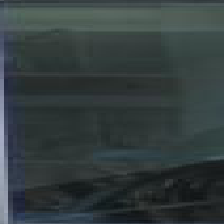

window



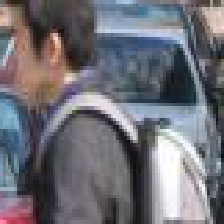

car



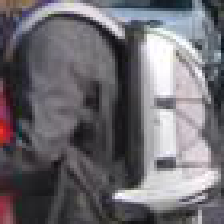

backpack



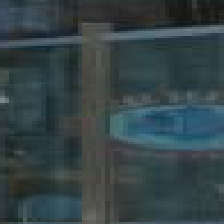

window



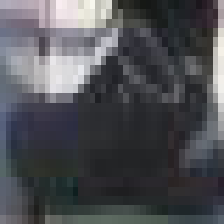

sneakers



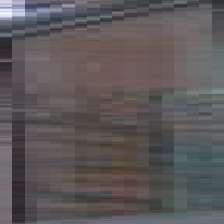

window



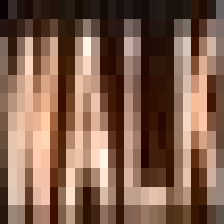

walk sign



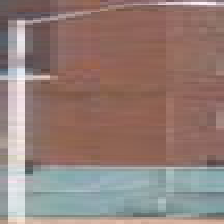

street light



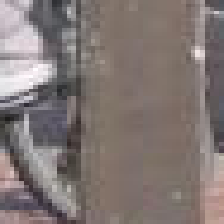

bike



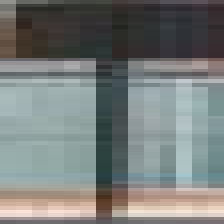

sign



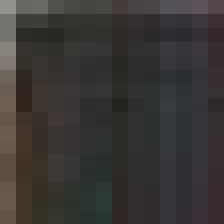

lights



In [8]:
preprocess_image(objects_info[2], attributes_info[2], display_images=True);

In [9]:
def preprocess_images(image_ids, save_path):
    failed = []
    wrong_mode = []
    
    object_squares = []
    img_ids = []
    original_sizes = []
    object_names = []
    attributes_names = []
    
    for image_id in image_ids:
        try:
            osq, ii, os, on, an = preprocess_image(objects_info[image_id], attributes_info[image_id])
        except requests.exceptions.HTTPError:
            failed.append(str(image_id))
            continue
        except WrongModeException:
            wrong_mode.append(str(image_id))
            continue
        except Exception as e:
            print(image_id)
            raise e
            
        object_squares.append(osq)
        img_ids.append(ii)
        original_sizes.append(os)
        object_names.append(on)
        attributes_names += an
        
    if failed:
        print('Failed to load image(s) {}'.format(', '.join(failed)))
        
    if wrong_mode:
        print('Wrong mode for image(s) {}'.format(', '.join(wrong_mode)))
        
    result = {
        'object_squares': np.concatenate(object_squares),
        'img_ids': np.concatenate(img_ids),
        'original_sizes': np.concatenate(original_sizes),
        'object_names': np.concatenate(object_names),
        'attributes_names': np.asarray(attributes_names)
    }

    if save_path is not None:
        np.savez_compressed(save_path, **result)

In [11]:
%store -r image_ids_list
image_ids_list.sort()

In [13]:
save_dir = os.path.join('./bounding_boxes')
interval = 1000
for k in range(0, len(image_ids_list), interval):
    slice_ = image_ids_list[k:k+interval]
    file_name = 'vg_bb_{:07}-{:07}.npz'.format(slice_[0], slice_[-1])
    save_path = os.path.join(save_dir,file_name)
    if os.path.exists(save_path):
        print('{}: {} already exists, skipping...'.format(k, file_name))
    else:
        print('{}: Generating {}'.format(k, file_name))
        preprocess_images(slice_, save_path=save_path)

0: vg_bb_0061512-0713571.npz already exists, skipping...
1000: vg_bb_0713581-1592717.npz already exists, skipping...
2000: vg_bb_1592718-2316913.npz already exists, skipping...
3000: vg_bb_2316917-2319008.npz already exists, skipping...
4000: vg_bb_2319016-2321101.npz already exists, skipping...
5000: vg_bb_2321102-2323251.npz already exists, skipping...
6000: vg_bb_2323252-2325422.npz already exists, skipping...
7000: vg_bb_2325423-2327552.npz already exists, skipping...
8000: vg_bb_2327553-2329758.npz already exists, skipping...
9000: vg_bb_2329763-2331956.npz already exists, skipping...
10000: vg_bb_2331961-2334158.npz already exists, skipping...
11000: vg_bb_2334160-2336327.npz already exists, skipping...
12000: vg_bb_2336328-2338442.npz already exists, skipping...
13000: vg_bb_2338444-2340692.npz already exists, skipping...
14000: vg_bb_2340693-2342822.npz already exists, skipping...
15000: vg_bb_2342825-2344943.npz already exists, skipping...
16000: vg_bb_2344944-2347022.npz alre

FileNotFoundError: [Errno 2] No such file or directory: '/home/ubuntu/Multimodal_Processing/bounding_boxes/vg_bb_2367797-2370013.npzhxqha7re-numpy.npy'